# Análise do [Dataset Student Depression](https://www.kaggle.com/datasets/hopesb/student-depression-dataset/data?select=Student+Depression+Dataset.csv)

Este notebook tem como objetivo demonstrar a criação de um projeto de Data Science, utilizando o dataset Student Depression para:
- Explorar e entender os dados.
- Realizar limpeza e transformações necessárias.
- Engajar engenharia de recursos simples.
- Treinar e avaliar modelos preditivos.

O Dataset Student Depression contém dados sobre a depressão entre estudantes de diferentes níveis de escolaridade.

## Importação das bibliotecas

In [1]:
# Importando o pandas para manipulação e leitura dos dados
import pandas as pd

import numpy as np

# Importando seaborn e matplotlib para criação de gráficos e visualizações
import seaborn as sns
import matplotlib.pyplot as plt

# Importando o statsmodels para modelagem estatística (ex.: regressão logística)
# e o módulo stepwise do pacote statstests para seleção de variáveis via procedimento stepwise
import statsmodels.api as sm
from statstests.process import stepwise

# Importando funções do scikit-learn para:
# - Métricas de avaliação (confusion matrix, accuracy, recall, etc.)
# - Divisão dos dados em conjuntos de treino e teste
# - Modelagem com árvores de decisão e visualização de árvores
from sklearn.metrics import (confusion_matrix, accuracy_score, ConfusionMatrixDisplay,
                             recall_score, roc_curve, auc, roc_auc_score,
                             balanced_accuracy_score, classification_report, mean_squared_error)
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

from xgboost import XGBClassifier
# Configurando o pandas para exibir todas as linhas do DataFrame durante a análise exploratória
pd.set_option("display.max_rows", None)

## Carregamento dos dados:

In [2]:

dataset_path = '../data/Student Depression Dataset.csv'
main = pd.read_csv(dataset_path)

## Cleaner and Exploration

In [3]:
print(main.shape, '\n')
main.head()

(27901, 18) 



,id,Gender,Age,City,Profession,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,Job Satisfaction,Sleep Duration,Dietary Habits,Degree,Have you ever had suicidal thoughts ?,Work/Study Hours,Financial Stress,Family History of Mental Illness,Depression
0,2,Male,33.0,Visakhapatnam,Student,5.0,0.0,8.97,2.0,0.0,5-6 hours,Healthy,B.Pharm,Yes,3.0,1.0,No,1
1,8,Female,24.0,Bangalore,Student,2.0,0.0,5.90,5.0,0.0,5-6 hours,Moderate,BSc,No,3.0,2.0,Yes,0
2,26,Male,31.0,Srinagar,Student,3.0,0.0,7.03,5.0,0.0,Less than 5 hours,Healthy,BA,No,9.0,1.0,Yes,0
3,30,Female,28.0,Varanasi,Student,3.0,0.0,5.59,2.0,0.0,7-8 hours,Moderate,BCA,Yes,4.0,5.0,Yes,1
4,32,Female,25.0,Jaipur,Student,4.0,0.0,8.13,3.0,0.0,5-6 hours,Moderate,M.Tech,Yes,1.0,1.0,No,0


In [4]:
main.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27901 entries, 0 to 27900
Data columns (total 18 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   id                                     27901 non-null  int64  
 1   Gender                                 27901 non-null  object 
 2   Age                                    27901 non-null  float64
 3   City                                   27901 non-null  object 
 4   Profession                             27901 non-null  object 
 5   Academic Pressure                      27901 non-null  float64
 6   Work Pressure                          27901 non-null  float64
 7   CGPA                                   27901 non-null  float64
 8   Study Satisfaction                     27901 non-null  float64
 9   Job Satisfaction                       27901 non-null  float64
 10  Sleep Duration                         27901 non-null  object 
 11  Di

In [5]:
# Removendo a coluna id
main.drop(columns=['id'], inplace=True)

In [6]:
# Validando valores nulos e nan:
print(f'Valores null:\n{main.isnull().sum()}\n')
print(f'Valores nan:\n{main.isna().sum()}\n')

Valores null:
Gender                                   0
Age                                      0
City                                     0
Profession                               0
Academic Pressure                        0
Work Pressure                            0
CGPA                                     0
Study Satisfaction                       0
Job Satisfaction                         0
Sleep Duration                           0
Dietary Habits                           0
Degree                                   0
Have you ever had suicidal thoughts ?    0
Work/Study Hours                         0
Financial Stress                         3
Family History of Mental Illness         0
Depression                               0
dtype: int64

Valores nan:
Gender                                   0
Age                                      0
City                                     0
Profession                               0
Academic Pressure                        0
Work Pressure

In [7]:
# Removendo os valores nulos e nan
main.dropna(inplace=True)

In [8]:
# Renomeando as colunas
main.rename(columns={
    'Academic Pressure': 'AP',
    'Work Pressure': 'WP',
    'Study Satisfaction': 'SS',
    'Job Satisfaction': 'JS',
    'Sleep Duration': 'SD',
    'Dietary Habits': 'DH',
    'Have you ever had suicidal thoughts ?': 'ST',
    'Work/Study Hours': 'WSH',
    'Financial Stress': 'FS',
    'Family History of Mental Illness': 'FHMI'
}, inplace=True)

In [9]:
# Selecionando colunas por tipo
columns_object = main.select_dtypes(include=['object']).columns.tolist()
columns_numeric = main.drop(columns=['Depression']).select_dtypes(
    include=['number']).columns.tolist()

# Exibindo os nomes das colunas
print('Feature columns:\n')
print(f"Columns Object: {columns_object} qtd:{len(columns_object)}\n")
print(f"Columns Numeric: {columns_numeric} qtd:{len(columns_numeric)}")

Feature columns:

Columns Object: ['Gender', 'City', 'Profession', 'SD', 'DH', 'Degree', 'ST', 'FHMI'] qtd:8

Columns Numeric: ['Age', 'AP', 'WP', 'CGPA', 'SS', 'JS', 'WSH', 'FS'] qtd:8


In [10]:
df = main.copy()

### Numeric variables

In [11]:
# Função para verificar outliers
def check_outliers(df):
    Q1 = df.quantile(q=.25)
    Q3 = df.quantile(q=.75)

    IQR = Q3 - Q1  # Calculando o valor do intervalo interquartil
    limit_lower = Q1 - 1.5 * IQR
    limit_upper = Q3 + 1.5 * IQR

    outliers_upper = df[(df > limit_upper)].sort_values().values
    outliers_lower = df[(df < limit_lower)].sort_values().values

    print(f'🔼 outliers_upper: {outliers_upper}')
    print(f'🔽 outliers_lower: {outliers_lower}')

    plt.figure(figsize=(8, 8))
    sns.boxplot(df)
    plt.show()

    return limit_lower, limit_upper

<Axes: >

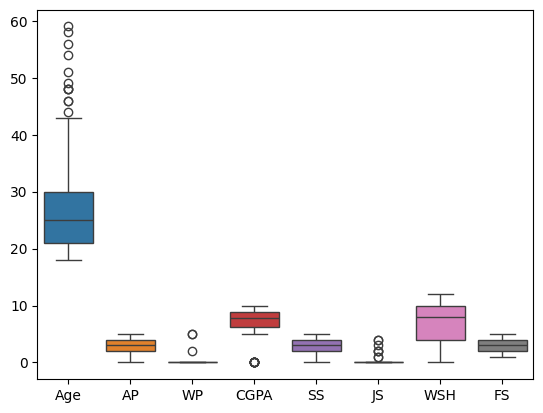

In [12]:
sns.boxplot(df[columns_numeric])

#### Age

🔼 outliers_upper: [44. 46. 46. 48. 48. 48. 49. 51. 54. 56. 58. 59.]
🔽 outliers_lower: []


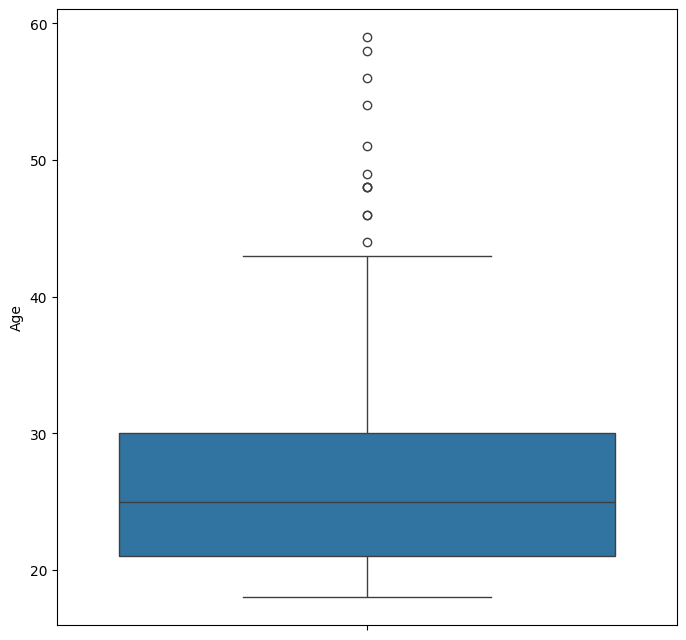

In [13]:
limit_lower, limit_upper = check_outliers(df['Age'])

In [14]:
# Removendo os outliers de idade
df.query('Age < @limit_upper', inplace=True)

#### WP

🔼 outliers_upper: [2. 5. 5.]
🔽 outliers_lower: []


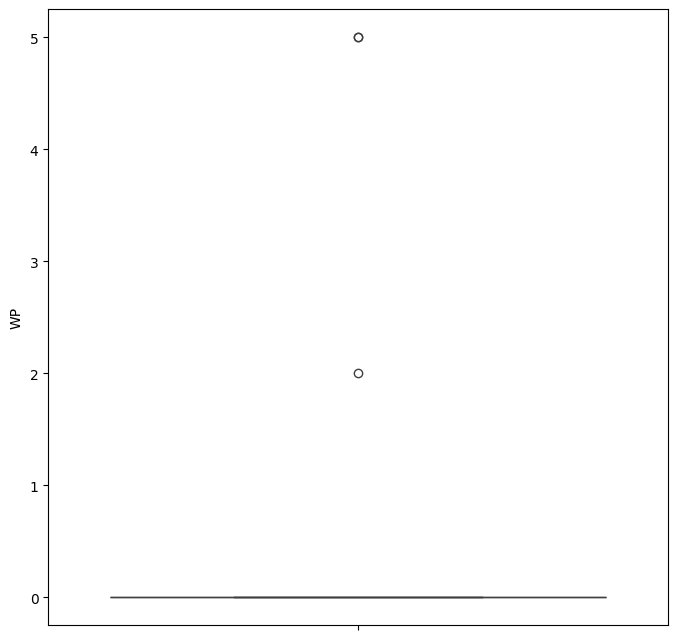

In [15]:
limit_lower, limit_upper = check_outliers(df['WP'])

In [16]:
# Removendo a vaeriavel WP por conta dela conter somente o valor 0
df.drop(columns=["WP"], inplace=True)

#### CGPA

🔼 outliers_upper: []
🔽 outliers_lower: [0. 0. 0. 0. 0. 0. 0. 0. 0.]


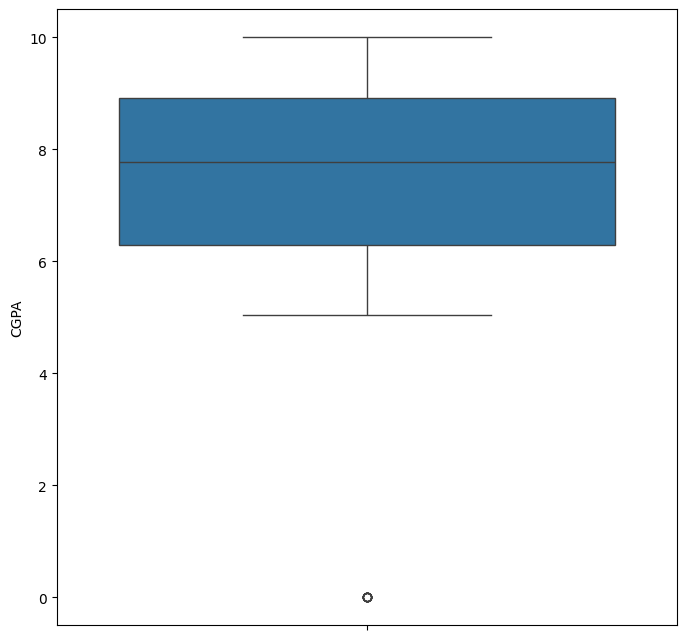

In [17]:
limit_lower, limit_upper = check_outliers(df['CGPA'])

In [18]:
df.query('CGPA > @limit_lower', inplace=True)

#### JS

🔼 outliers_upper: [2. 3.]
🔽 outliers_lower: []


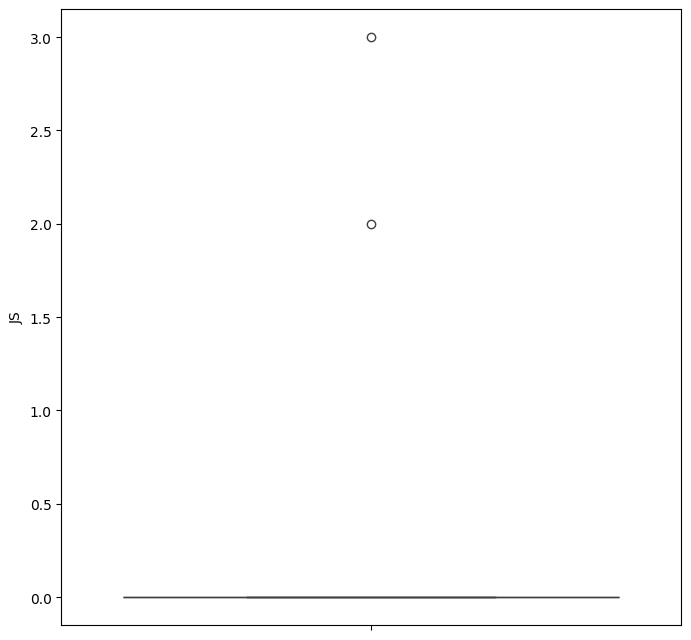

In [19]:
limit_lower, limit_upper = check_outliers(df['JS'])

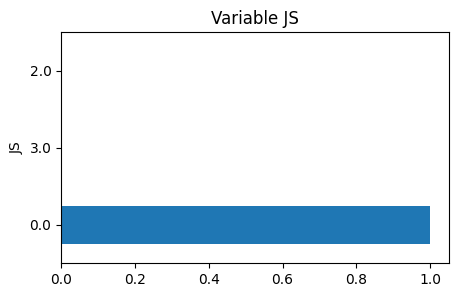

In [20]:
plt.figure(figsize=(5, 3))
plt.title("Variable JS")
df['JS'].value_counts(normalize=True).plot.barh()
plt.show()

In [21]:
# Removendo a vaeriavel Js por conta dela conter somente o valor 0
df.drop(columns=["JS"], inplace=True)

<Axes: >

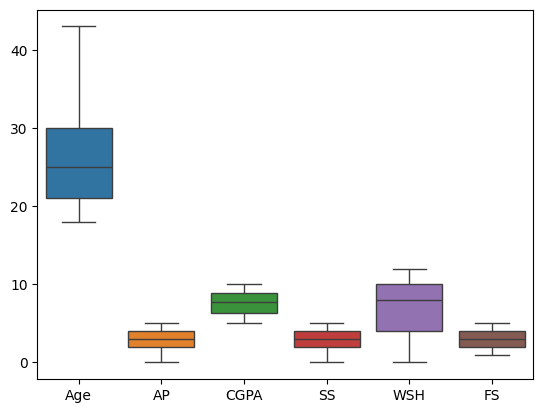

In [22]:
columns_numeric = df.drop(columns=['Depression']).select_dtypes(
    include=['number']).columns.tolist()
sns.boxplot(df[columns_numeric])

### Categoric Variables

In [23]:
# Plotagem do grafico de torta
def pie_plot(data, labels, title):
    plt.figure(figsize=(6, 6))
    plt.pie(data, labels=labels, autopct='%1.1f%%')
    plt.title(title)
    plt.show()

#### Gender

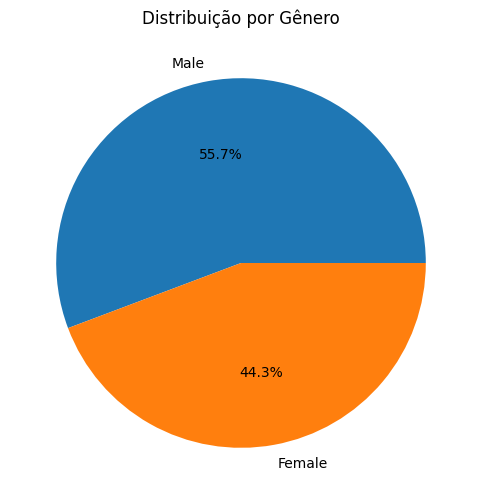

In [24]:
gender_counts = df['Gender'].value_counts()
pie_plot(data=gender_counts, labels=gender_counts.index,
         title='Distribuição por Gênero')

In [25]:
# Trocar para variavel dummy
df['Gender'] = df['Gender'].map({'Male': 0, 'Female': 1})

#### City

In [26]:
df['City'].value_counts()

City
Kalyan                1570
Srinagar              1371
Hyderabad             1339
Vasai-Virar           1290
Lucknow               1153
Thane                 1139
Ludhiana              1110
Agra                  1093
Surat                 1077
Kolkata               1065
Jaipur                1036
Patna                 1007
Visakhapatnam          969
Pune                   967
Ahmedabad              949
Bhopal                 933
Chennai                883
Meerut                 824
Rajkot                 814
Delhi                  768
Bangalore              767
Ghaziabad              744
Mumbai                 699
Vadodara               692
Varanasi               684
Nagpur                 650
Indore                 643
Kanpur                 609
Nashik                 545
Faridabad              461
Saanvi                   2
Bhavna                   2
City                     2
Harsha                   2
Less Delhi               1
M.Tech                   1
3.0                    

In [27]:
# Vamos pegar a cidades que tem mais de 2
filtered_cities = df['City'].value_counts()[lambda x: x > 2].index
print(filtered_cities)
df.query('City in @filtered_cities', inplace=True)

Index(['Kalyan', 'Srinagar', 'Hyderabad', 'Vasai-Virar', 'Lucknow', 'Thane',
       'Ludhiana', 'Agra', 'Surat', 'Kolkata', 'Jaipur', 'Patna',
       'Visakhapatnam', 'Pune', 'Ahmedabad', 'Bhopal', 'Chennai', 'Meerut',
       'Rajkot', 'Delhi', 'Bangalore', 'Ghaziabad', 'Mumbai', 'Vadodara',
       'Varanasi', 'Nagpur', 'Indore', 'Kanpur', 'Nashik', 'Faridabad'],
      dtype='object', name='City')


In [28]:
# Vamos criar uma nova coluna de estado utilizei o chat gpt para dividir as cidades da India por estado

city_to_state = {
    'Visakhapatnam': 'Andhra_Pradesh',
    'Bangalore': 'Karnataka',
    'Srinagar': 'Jammu_and_Kashmir',
    'Varanasi': 'Uttar_Pradesh',
    'Jaipur': 'Rajasthan',
    'Pune': 'Maharashtra',
    'Thane': 'Maharashtra',
    'Chennai': 'Tamil_Nadu',
    'Nagpur': 'Maharashtra',
    'Nashik': 'Maharashtra',
    'Vadodara': 'Gujarat',
    'Kalyan': 'Maharashtra',
    'Rajkot': 'Gujarat',
    'Ahmedabad': 'Gujarat',
    'Kolkata': 'West_Bengal',
    'Mumbai': 'Maharashtra',
    'Lucknow': 'Uttar_Pradesh',
    'Indore': 'Madhya_Pradesh',
    'Surat': 'Gujarat',
    'Ludhiana': 'Punjab',
    'Bhopal': 'Madhya_Pradesh',
    'Meerut': 'Uttar_Pradesh',
    'Agra': 'Uttar_Pradesh',
    'Ghaziabad': 'Uttar_Pradesh',
    'Hyderabad': 'Telangana',
    'Vasai-Virar': 'Maharashtra',
    'Kanpur': 'Uttar_Pradesh',
    'Patna': 'Bihar',
    'Faridabad': 'Haryana',
    'Delhi': 'Delhi'
}

df['State'] = df['City'].map(city_to_state)

#### State

In [29]:
df['State'].value_counts(normalize=True)

State
Maharashtra          0.246311
Uttar_Pradesh        0.183369
Gujarat              0.126818
Madhya_Pradesh       0.056587
Jammu_and_Kashmir    0.049226
Telangana            0.048077
Punjab               0.039855
West_Bengal          0.038239
Rajasthan            0.037198
Bihar                0.036157
Andhra_Pradesh       0.034792
Tamil_Nadu           0.031704
Delhi                0.027575
Karnataka            0.027539
Haryana              0.016552
Name: proportion, dtype: float64

In [30]:
# Vamos remover a coluna de cidades e criar uma dummy para estados
dummies = pd.get_dummies(df['State'], dtype=int)
df = pd.concat([df, dummies], axis=1)
df.drop(columns=['City', 'State'], inplace=True)

#### Profession

In [31]:
df['Profession'].value_counts(normalize=True)

Profession
Student                   0.998887
Architect                 0.000287
Teacher                   0.000215
Digital Marketer          0.000108
Chef                      0.000072
Content Writer            0.000072
Pharmacist                0.000072
Doctor                    0.000072
UX/UI Designer            0.000036
Civil Engineer            0.000036
Manager                   0.000036
Educational Consultant    0.000036
Lawyer                    0.000036
Entrepreneur              0.000036
Name: proportion, dtype: float64

In [32]:
# Vamos ficar somente com a profissao de estudante visto que ela ja esta com mais 99% da nossa base
df.query('Profession == "Student"', inplace=True)

In [33]:
# Visto que agora nossos dados são somente de estudandes não tem sentido de manter esta coluna
df.drop(columns=['Profession'], inplace=True)

#### SD

In [34]:
df['SD'].value_counts(normalize=True)

SD
Less than 5 hours    0.297915
7-8 hours            0.263156
5-6 hours            0.221567
More than 8 hours    0.216715
Others               0.000647
Name: proportion, dtype: float64

In [35]:
# Vamos remover a variavel Others visto que sua significancia para o modelo e muito pequena
df.query('SD != "Others"', inplace=True)

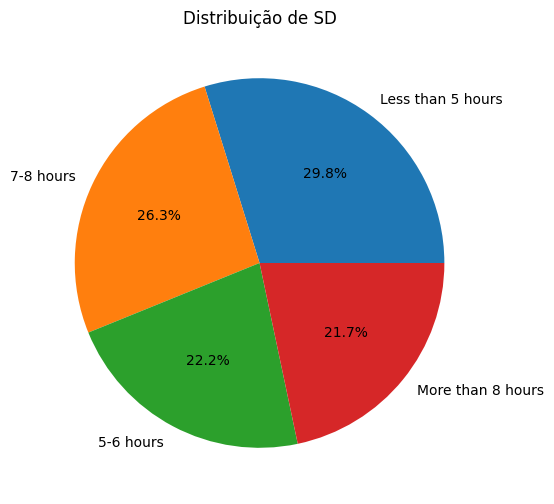

In [36]:
sd_counts = df['SD'].value_counts()
pie_plot(data=sd_counts, labels=sd_counts.index,
         title='Distribuição de SD')

In [37]:
# Vou renomear as variaveis pos o statsmodels não aceita que comece por numero

rename_sd_variable = {
    'Less than 5 hours': 'less_than_five_hours',
    '7-8 hours': 'seven_eight_hours',
    '5-6 hours': 'five_six_hours',
    'More than 8 hours': 'more_than_eight_five_six_hours'}

df['SD'] = df['SD'].map(rename_sd_variable)

In [38]:
# Vamos dummizar a coluna do SD
dummies = pd.get_dummies(df['SD'], dtype=int)
df = pd.concat([df, dummies], axis=1)
df.drop(columns=['SD'], inplace=True)

#### DH

In [39]:
df['DH'].value_counts(normalize=True)

DH
Unhealthy    0.369686
Moderate     0.355730
Healthy      0.274153
Others       0.000432
Name: proportion, dtype: float64

In [40]:
# Vamos remover a variavel Others visto que sua significancia para o modelo e muito pequena
df.query('DH != "Others"', inplace=True)

In [41]:
dummies = pd.get_dummies(df['DH'], dtype=int)
df = pd.concat([df, dummies], axis=1)
df.drop(columns=['DH'], inplace=True)

#### Degree

In [42]:
df['Degree'].value_counts()

Degree
Class 12    6064
B.Ed        1857
B.Com       1503
B.Arch      1475
BCA         1428
MSc         1183
B.Tech      1151
MCA         1038
M.Tech      1019
BHM          921
BSc          881
M.Ed         816
B.Pharm      808
M.Com        733
BBA          694
MBBS         692
LLB          668
BE           608
BA           594
M.Pharm      580
MD           567
MBA          560
MA           542
PhD          517
LLM          480
MHM          191
ME           185
Others        35
Name: count, dtype: int64

In [43]:
# Vamos remover a variavel Others visto que sua significancia para o modelo e muito pequena
df.query('Degree != "Others"', inplace=True)

In [44]:
# Vamos mapear degree para secondary_education, postgraduate_degree and undergraduate_degree i use chatgpt to map
def categorize_education(degree):
    if degree == "Class 12":
        return 'secondary_education'
    elif degree in ["PhD", "MSc", "MHM", "ME", "MD", "MCA", "MBBS", "MBA", "MA",
                    "M.Tech", "M.Pharm", "M.Ed", "M.Com", "LLM"]:
        return 'postgraduate_degree'
    elif degree in ["LLB", "BSc", "BHM", "BE", "BCA", "BBA", "BA", "B.Tech",
                    "B.Pharm", "B.Ed", "B.Com", "B.Arch"]:
        return 'undergraduate_degree'


df["Degree"] = df["Degree"].apply(categorize_education).astype('object')

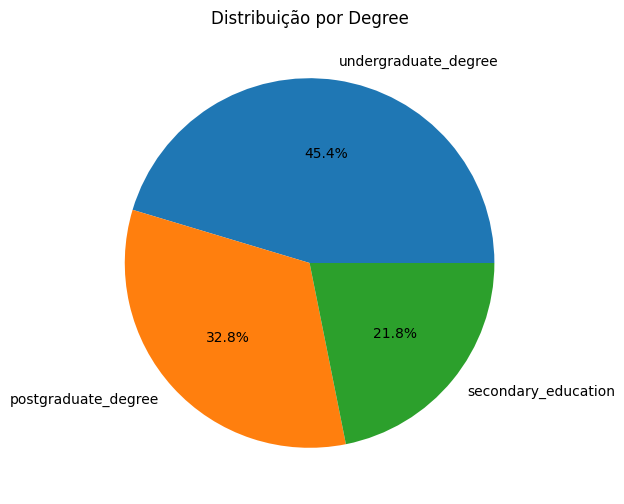

In [45]:
degree_counts = df['Degree'].value_counts()
pie_plot(data=degree_counts, labels=degree_counts.index,
         title='Distribuição por Degree')

In [46]:
dummies = pd.get_dummies(df['Degree'], dtype=int)
df = pd.concat([df, dummies], axis=1)
df.drop(columns=['Degree'], inplace=True)

#### ST

In [47]:
df['ST'].value_counts(normalize=True)

ST
Yes    0.632787
No     0.367213
Name: proportion, dtype: float64

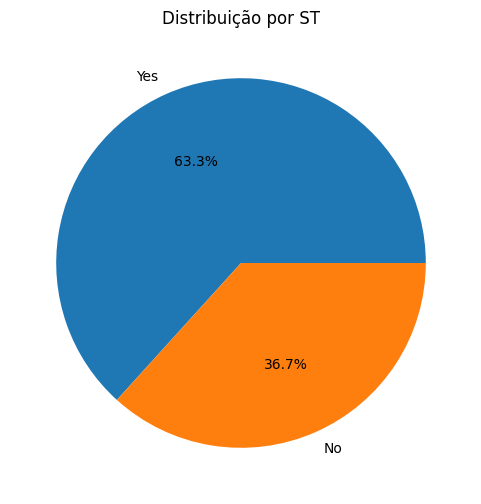

In [48]:
st_counts = df['ST'].value_counts()
pie_plot(data=st_counts, labels=st_counts.index,
         title='Distribuição por ST')

In [49]:
# Trocar para variavel dummy
df['ST'] = df['ST'].map({'No': 0, 'Yes': 1})

#### FHMI

In [50]:
df['FHMI'].value_counts(normalize=True)

FHMI
No     0.515871
Yes    0.484129
Name: proportion, dtype: float64

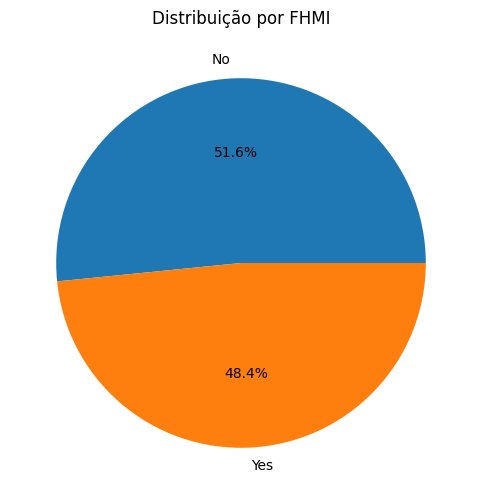

In [51]:
fhmi_counts = df['FHMI'].value_counts()
pie_plot(data=fhmi_counts, labels=fhmi_counts.index,
         title='Distribuição por FHMI')

In [52]:
df['FHMI'] = df['FHMI'].map({'No': 0, 'Yes': 1})

In [53]:
print(df.shape)
df.head()

(27755, 35)


,Gender,Age,AP,CGPA,SS,ST,WSH,FS,FHMI,Depression,...,five_six_hours,less_than_five_hours,more_than_eight_five_six_hours,seven_eight_hours,Healthy,Moderate,Unhealthy,postgraduate_degree,secondary_education,undergraduate_degree
0,0,33.0,5.0,8.97,2.0,1,3.0,1.0,0,1,...,1,0,0,0,1,0,0,0,0,1
1,1,24.0,2.0,5.90,5.0,0,3.0,2.0,1,0,...,1,0,0,0,0,1,0,0,0,1
2,0,31.0,3.0,7.03,5.0,0,9.0,1.0,1,0,...,0,1,0,0,1,0,0,0,0,1
3,1,28.0,3.0,5.59,2.0,1,4.0,5.0,1,1,...,0,0,0,1,0,1,0,0,0,1
4,1,25.0,4.0,8.13,3.0,1,1.0,1.0,0,0,...,1,0,0,0,0,1,0,1,0,0


### Validando o DataSet

In [54]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 27755 entries, 0 to 27900
Data columns (total 35 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Gender                          27755 non-null  int64  
 1   Age                             27755 non-null  float64
 2   AP                              27755 non-null  float64
 3   CGPA                            27755 non-null  float64
 4   SS                              27755 non-null  float64
 5   ST                              27755 non-null  int64  
 6   WSH                             27755 non-null  float64
 7   FS                              27755 non-null  float64
 8   FHMI                            27755 non-null  int64  
 9   Depression                      27755 non-null  int64  
 10  Andhra_Pradesh                  27755 non-null  int64  
 11  Bihar                           27755 non-null  int64  
 12  Delhi                           27755

In [55]:
df.to_parquet('../data/Student Depression Dataset Treat.parquet')

## Modelagem e Treinamento

In [56]:
df_models_result = pd.DataFrame()


def models_statistics(model_name, observated, predicts, regression=False):

    values = np.array(predicts)  # Converte qualquer entrada para numpy array

    if regression:
        cut_off = 0.5
        values = np.where(values > cut_off, 1, 0)  # Converte para binário

    cm = confusion_matrix(observated, values)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.title('Confusion Matrix')
    plt.xlabel('True')
    plt.ylabel('Classified')
    plt.gca().invert_xaxis()
    plt.gca().invert_yaxis()
    plt.show()

    sensitivity = recall_score(observated, values, pos_label=1)
    specificity = recall_score(observated, values, pos_label=0)
    accuracy = accuracy_score(observated, values)
    balanced_accuracy = balanced_accuracy_score(observated, values)
    mse = mean_squared_error(observated, values)
    rmse = np.sqrt(mse)

    indicators = pd.DataFrame({
        'Model_Name': [model_name],
        'Sensitivity': [sensitivity],
        'Specificity': [specificity],
        'Accuracy': [accuracy],
        'Balanced_Accuracy': [balanced_accuracy],
        'MSE': [mse],
        'RMSE': [rmse]
    })

    fpr, tpr, _ = roc_curve(observated, values)
    roc_auc = auc(fpr, tpr)
    gini = (roc_auc - 0.5) / 0.5

    # Plotando a curva ROC
    plt.figure(figsize=(10, 7))
    plt.plot(fpr, tpr, marker='o', color='darkorchid',
             markersize=10, linewidth=3)
    plt.plot(fpr, fpr, color='gray', linestyle='dashed')
    plt.title(
        f'Área abaixo da curva: {round(roc_auc, 4)} | Coeficiente de GINI: {round(gini, 4)}', fontsize=22)
    plt.xlabel('1 - Especificidade', fontsize=20)
    plt.ylabel('Sensitividade', fontsize=20)
    plt.xticks(np.arange(0, 1.1, 0.2), fontsize=14)
    plt.yticks(np.arange(0, 1.1, 0.2), fontsize=14)
    plt.show()

    print(indicators.T)

    return indicators

## Modelo Logisitico

In [57]:
df.columns = df.columns.str.replace(r'\s|-', '_', regex=True)
list_colums_dummies = list(df.drop(columns=['Depression']).columns)
formula_dummies_model = ' + '.join(list_colums_dummies)
formula_dummies_model = 'Depression ~ ' + formula_dummies_model
formula_dummies_model

'Depression ~ Gender + Age + AP + CGPA + SS + ST + WSH + FS + FHMI + Andhra_Pradesh + Bihar + Delhi + Gujarat + Haryana + Jammu_and_Kashmir + Karnataka + Madhya_Pradesh + Maharashtra + Punjab + Rajasthan + Tamil_Nadu + Telangana + Uttar_Pradesh + West_Bengal + five_six_hours + less_than_five_hours + more_than_eight_five_six_hours + seven_eight_hours + Healthy + Moderate + Unhealthy + postgraduate_degree + secondary_education + undergraduate_degree'

### Realizando o treino do modelo:

In [58]:
model = sm.Logit.from_formula(formula_dummies_model, df).fit()

model.summary()

Optimization terminated successfully.
         Current function value: 0.347921
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:             Depression   No. Observations:                27755
Model:                          Logit   Df Residuals:                    27724
Method:                           MLE   Df Model:                           30
Date:                Sat, 15 Feb 2025   Pseudo R-squ.:                  0.4872
Time:                        20:08:54   Log-Likelihood:                -9656.6
converged:                       True   LL-Null:                       -18831.
Covariance Type:            nonrobust   LLR p-value:                     0.000
==================================================================================================
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept                         -1.5404        nan        nan        nan         nan         nan
Gender                             0.0082      0.037      0.223      0.824      -0.064       0.081
Age                               -0.1183      0.005    -24.353      0.000      -0.128      -0.109
AP                                 0.8388      0.015     56.042      0.000       0.809       0.868
CGPA                               0.0562      0.013      4.484      0.000       0.032       0.081
SS                                -0.2427      0.014    -17.782      0.000      -0.269      -0.216
ST                                 2.5150      0.039     64.025      0.000       2.438       2.592
WSH                                0.1176      0.005     23.538      0.000       0.108       0.127
FS                                 0.5532      0.013     41.298      0.000       0.527       0.579
FHMI                               0.2440      0.037      6.673      0.000       0.172       0.316
Andhra_Pradesh                    -0.1192      1e+06  -1.19e-07      1.000   -1.97e+06    1.97e+06
Bihar                              0.0620   8.72e+05   7.11e-08      1.000   -1.71e+06    1.71e+06
Delhi                             -0.0738   1.26e+06  -5.87e-08      1.000   -2.47e+06    2.47e+06
Gujarat                           -0.0648   9.94e+05  -6.52e-08      1.000   -1.95e+06    1.95e+06
Haryana                           -0.0134   1.18e+06  -1.13e-08      1.000   -2.32e+06    2.32e+06
Jammu_and_Kashmir                 -0.2022    9.7e+05  -2.08e-07      1.000    -1.9e+06     1.9e+06
Karnataka                         -0.0735   6.75e+05  -1.09e-07      1.000   -1.32e+06    1.32e+06
Madhya_Pradesh                    -0.0596   1.04e+06  -5.75e-08      1.000   -2.03e+06    2.03e+06
Maharashtra                       -0.1943   6.12e+05  -3.18e-07      1.000    -1.2e+06     1.2e+06
Punjab                            -0.0886    1.2e+06  -7.36e-08      1.000   -2.36e+06    2.36e+06
Rajasthan                         -0.4000   9.53e+05   -4.2e-07      1.000   -1.87e+06    1.87e+06
Tamil_Nadu                        -0.2485   1.07e+06  -2.32e-07      1.000    -2.1e+06     2.1e+06
Telangana                          0.1325   6.58e+05   2.01e-07      1.000   -1.29e+06    1.29e+06
Uttar_Pradesh                     -0.2295   1.24e+06  -1.85e-07      1.000   -2.43e+06    2.43e+06
West_Bengal                        0.0325   1.06e+06   3.07e-08      1.000   -2.07e+06    2.07e+06
five_six_hours                    -0.4185        nan        nan        nan         nan         nan
less_than_five_hours              -0.0467        nan        nan        nan         nan         nan
more_than_eight_five_six_hours    -0.6726        nan        nan        nan         nan         nan
seven_eight_hours                 -0.4026        nan        nan        nan         nan         nan
Healthy                           -1.0365   8.31e+05  -1.25e-06      1.00

### Executando o processo de stepwise para remoção de variaveis.

In [59]:
stepwise_model = stepwise(model, pvalue_limit=0.05)

Regression type: Logit 

Estimating model...: 
 Depression ~ Q('Gender') + Q('Age') + Q('AP') + Q('CGPA') + Q('SS') + Q('ST') + Q('WSH') + Q('FS') + Q('FHMI') + Q('Andhra_Pradesh') + Q('Bihar') + Q('Delhi') + Q('Gujarat') + Q('Haryana') + Q('Jammu_and_Kashmir') + Q('Karnataka') + Q('Madhya_Pradesh') + Q('Maharashtra') + Q('Punjab') + Q('Rajasthan') + Q('Tamil_Nadu') + Q('Telangana') + Q('Uttar_Pradesh') + Q('West_Bengal') + Q('five_six_hours') + Q('less_than_five_hours') + Q('more_than_eight_five_six_hours') + Q('seven_eight_hours') + Q('Healthy') + Q('Moderate') + Q('Unhealthy') + Q('postgraduate_degree') + Q('secondary_education') + Q('undergraduate_degree')
Optimization terminated successfully.
         Current function value: 0.347921
         Iterations 7

 Discarding atribute "Q('Haryana')" with p-value equal to 0.9999999909806911 

Estimating model...: 
 Depression ~ Q('Gender') + Q('Age') + Q('AP') + Q('CGPA') + Q('SS') + Q('ST') + Q('WSH') + Q('FS') + Q('FHMI') + Q('Andhra_Pra

### Analisando os resultados do modelo

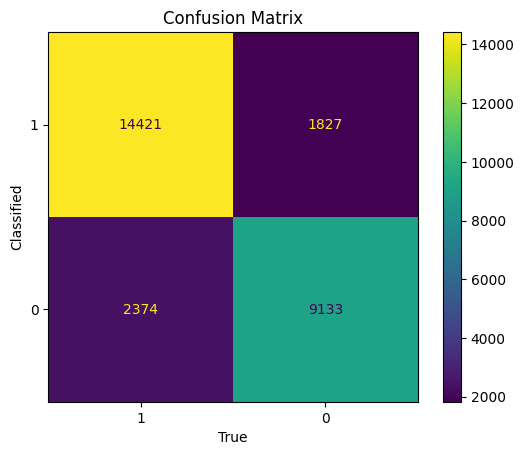

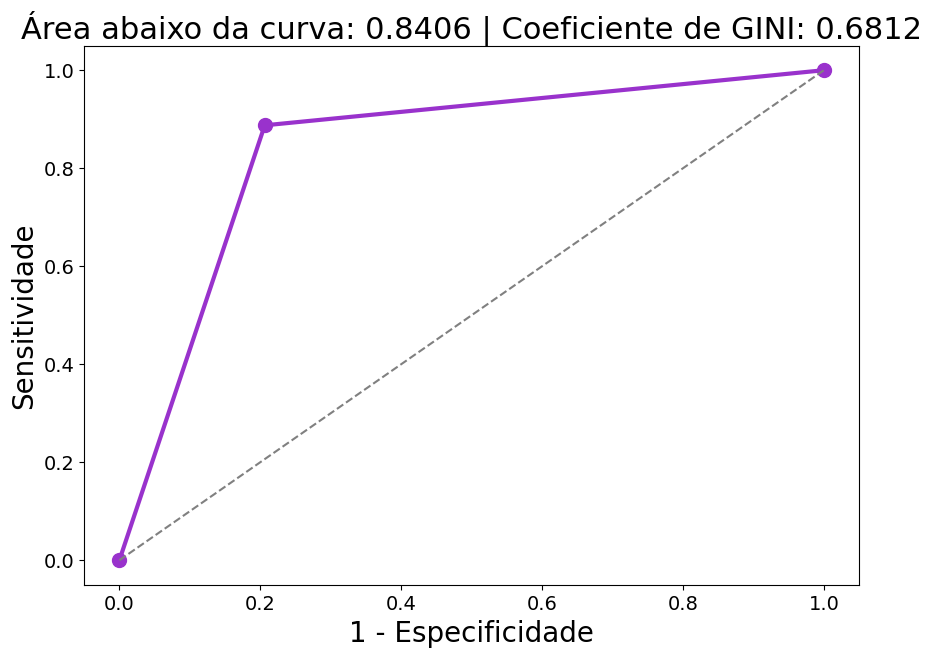

                                     0
Model_Name         regression logistic
Sensitivity                   0.887555
Specificity                   0.793691
Accuracy                       0.84864
Balanced_Accuracy             0.840623
MSE                            0.15136
RMSE                           0.38905


In [60]:
predict = stepwise_model.predict(df.drop(columns=["Depression"]))
model_indicators = models_statistics(model_name='regression logistic', observated=df['Depression'],
                                     predicts=predict, regression=True)

df_models_result = pd.concat(
    [df_models_result, model_indicators], ignore_index=True)

## Árvore de Decisão

### Separando as variasveis preditoras da target

In [61]:
X = df.drop(columns=['Depression'])
y = df['Depression']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(22204, 34)
(22204,)
(5551, 34)
(5551,)


In [62]:
clf = DecisionTreeClassifier(criterion='gini',
                             max_depth=3).fit(X_train, y_train)

In [63]:
param_grid = {
    'max_depth': [3, 5, 10, 15, 20, 25, 30],
    'min_samples_split': [2, 5, 10, 15],
    'criterion': ['gini', 'entropy']
}

grid_decision_tree = GridSearchCV(estimator=clf,
                                  param_grid=param_grid,
                                  cv=5,
                                  scoring='accuracy')

grid_decision_tree.fit(X_train, y_train)

print("Best Hyperparameters:", grid_decision_tree.best_params_)
print("Best Accuracy:", grid_decision_tree.best_score_)

Best Hyperparameters: {'criterion': 'entropy', 'max_depth': 5, 'min_samples_split': 2}
Best Accuracy: 0.8257523972970944


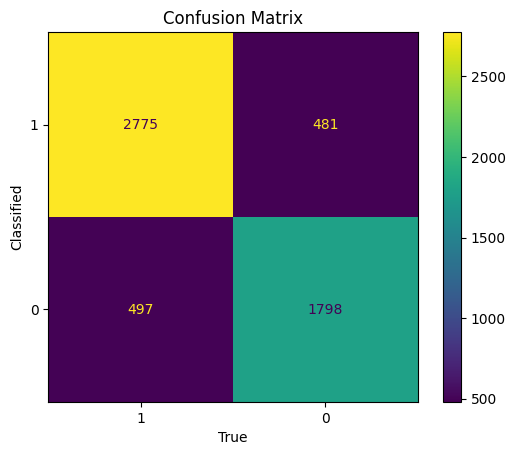

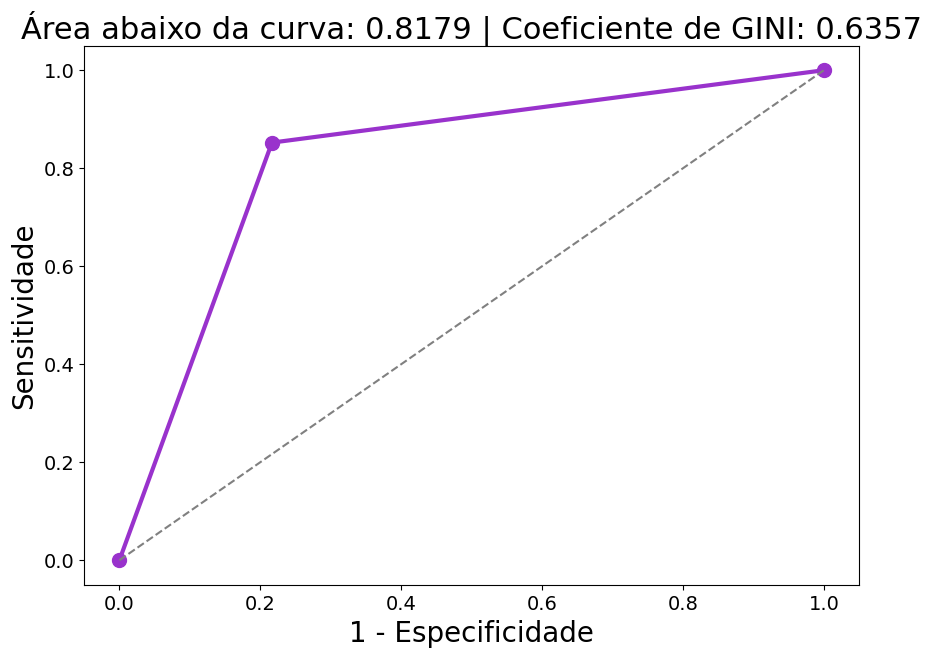

                                          0
Model_Name         decision tree classifier
Sensitivity                        0.852273
Specificity                        0.783442
Accuracy                           0.823816
Balanced_Accuracy                  0.817857
MSE                                0.176184
RMSE                               0.419743


In [64]:
clf = grid_decision_tree.best_estimator_
predict = clf.predict(X_test)

model_indicators = models_statistics(model_name='decision tree classifier',
                                     observated=y_test, predicts=predict)

df_models_result = pd.concat(
    [df_models_result, model_indicators], ignore_index=True)

In [65]:
param_grid = {'n_estimators': [100, 200],
              'max_depth': [2, 4, 8],
              'max_features': [5, 10, 15],
              'criterion': ['gini', 'entropy']
              }

grid_rf = GridSearchCV(estimator=RandomForestClassifier(),
                       param_grid=param_grid,
                       cv=5)

grid_rf.fit(X_train, y_train)

print("Best Hyperparameters:", grid_rf.best_params_)
print("Best Accuracy:", grid_rf.best_score_)

Best Hyperparameters: {'criterion': 'gini', 'max_depth': 8, 'max_features': 15, 'n_estimators': 200}
Best Accuracy: 0.8416504784451193


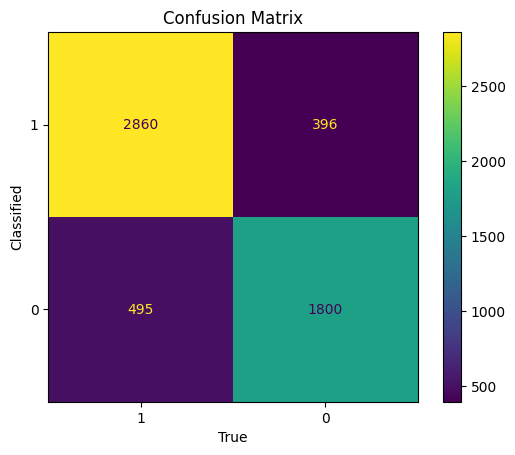

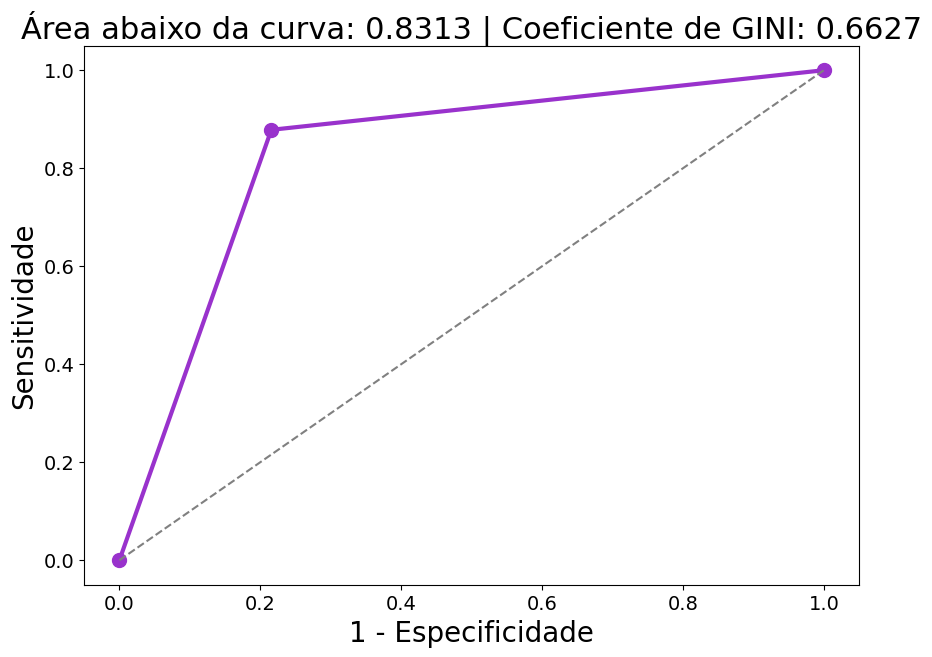

                                          0
Model_Name         random forest classifier
Sensitivity                        0.878378
Specificity                        0.784314
Accuracy                           0.839488
Balanced_Accuracy                  0.831346
MSE                                0.160512
RMSE                               0.400639


In [66]:
rf = grid_rf.best_estimator_
predict = rf.predict(X_test)
model_indicators = models_statistics(model_name='random forest classifier',
                                     observated=y_test, predicts=predict)

df_models_result = pd.concat(
    [df_models_result, model_indicators], ignore_index=True)

In [67]:
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [2, 3],
    'gamma': [0],
    'learning_rate': [0.1, 0.4],
    'colsample_bytree': [0.6, 0.8],
    'min_child_weight': [1],
    'subsample': [0.75, 1]
}

grid_search_xgb = GridSearchCV(estimator=XGBClassifier(objective='binary:logistic'), param_grid=param_grid,
                               scoring='roc_auc', cv=10, verbose=0, n_jobs=-1).fit(X_train, y_train)

print("Best Hyperparameters:", grid_search_xgb.best_params_)
print("Best Accuracy:", np.round(grid_search_xgb.best_score_, 4))

Best Hyperparameters: {'colsample_bytree': 0.6, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 150, 'subsample': 1}
Best Accuracy: 0.9219


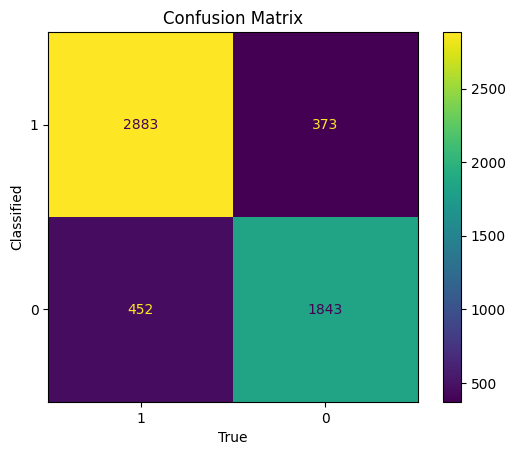

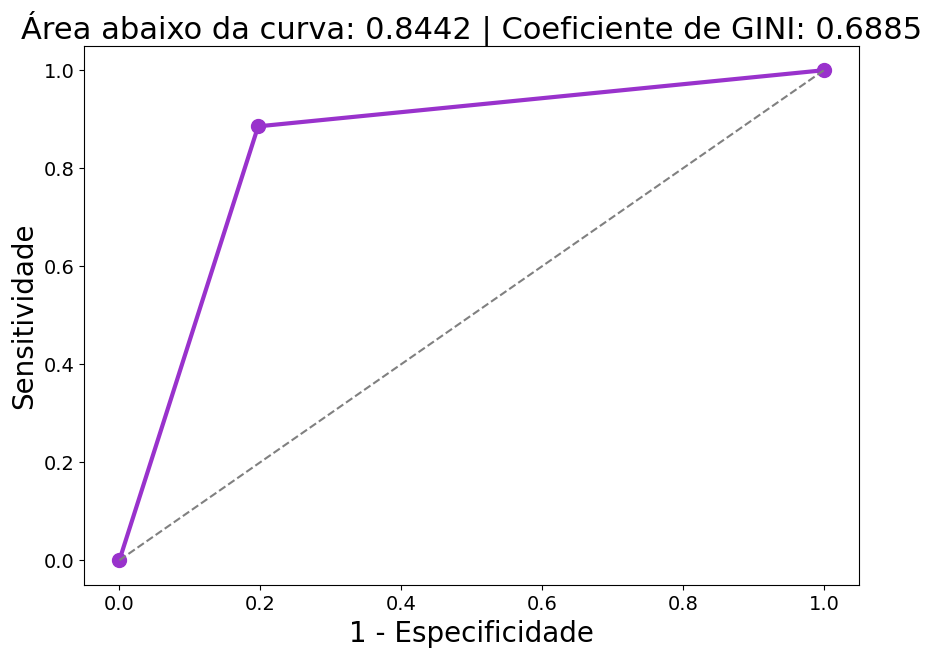

                               0
Model_Name         xgbclassifier
Sensitivity             0.885442
Specificity              0.80305
Accuracy                0.851378
Balanced_Accuracy       0.844246
MSE                     0.148622
RMSE                    0.385515


In [68]:
xgb = grid_search_xgb.best_estimator_

predict = xgb.predict(X_test)
model_indicators = models_statistics(model_name='xgbclassifier',
                                     observated=y_test, predicts=predict)

df_models_result = pd.concat(
    [df_models_result, model_indicators], ignore_index=True)

## Resultados

In [69]:
df_models_result.sort_values(by="Balanced_Accuracy", ascending=False)

,Model_Name,Sensitivity,Specificity,Accuracy,Balanced_Accuracy,MSE,RMSE
3,xgbclassifier,0.885442,0.803050,0.851378,0.844246,0.148622,0.385515
0,regression logistic,0.887555,0.793691,0.848640,0.840623,0.151360,0.389050
2,random forest classifier,0.878378,0.784314,0.839488,0.831346,0.160512,0.400639
1,decision tree classifier,0.852273,0.783442,0.823816,0.817857,0.176184,0.419743
